In [2]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from scipy import stats
import seaborn as sns
import oneshot as sm
import rfm, skipRFM, deepSkip, localSkip, localDeepSkip

import torch, time
from torch import nn
import config


kwargs = {200:{'error_threshold': 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.094},\
          22:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.043},\
          12:{'error_threshold' : 0.25, 'dt': 0.25, 'Lyapunov_time': 1/0.003}}

L = 22
dynamical_system = f'KS-{L}'
folder = f'../data/{dynamical_system}'
Uo = torch.tensor(np.load(f'../data/{dynamical_system}/train.npy'))[:,:100000]
Vo = torch.tensor(np.load(f'../data/{dynamical_system}/test.npy'))
# ut.gather_beta(dynamical_system)

**beta vs VPT**

FileNotFoundError: [Errno 2] No such file or directory: '../data/KS-22/config_test_22/SkipRFM/beta/beta_D_r-2048_B-1.csv'

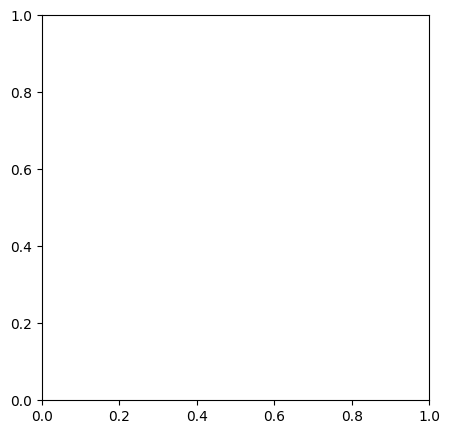

In [3]:
config = f'config_test_{L}'
D_r, B, n = 2048, 1, 10
data_folder = f"{folder}/{config}"
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
for architecture in ['SkipRFM', 'LocalSkip_12_1', 'LocalSkip_8_1']:
    data = pd.read_csv(f'{data_folder}/{architecture}/beta/beta_D_r-{D_r}_B-{B}.csv')
    x, y = data['beta'], data['tau_f_nmse_mean']
    x, y = ut.smooth(x, y, 5)
    x_ = np.log10(x)
    y_ = np.log2(y)
    ax.plot(x_, y_, label=f'{architecture}')
    ax.set_xlabel(r'$\log_{10}(\beta)$')
    ax.set_ylabel(r'$\log_{2}(\mathbb{E}[\text{VPT}])$')
ax.legend()
plt.savefig(f"../data/plots/{dynamical_system}-beta-vs-VPT.png", bbox_inches="tight", dpi=300)

**Covariance structure**

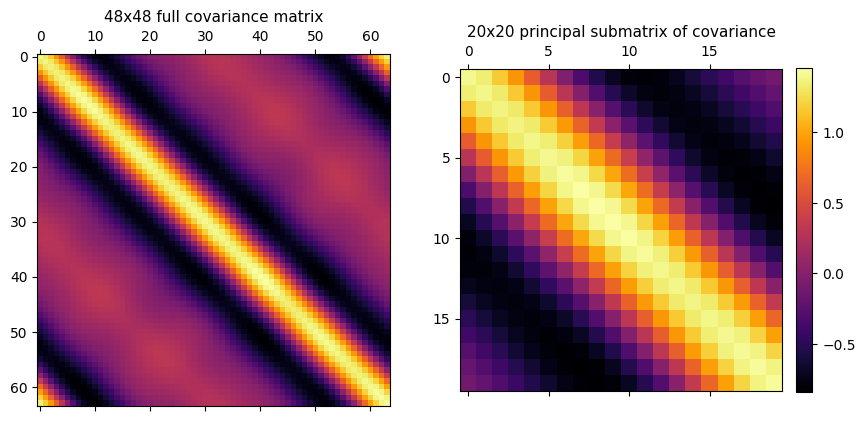

In [3]:
cov = np.cov(Uo)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
ax.matshow(cov, cmap='inferno')
im = ax1.matshow(cov[:20, :20], cmap='inferno')
ax.set_title("48x48 full covariance matrix", fontsize=11)
ax1.set_title("20x20 principal submatrix of covariance", fontsize=11)
fig.colorbar(im, fraction=0.046, pad=0.04)
plt.savefig(f"../data/plots/{dynamical_system}-cov.png", bbox_inches="tight", dpi=300)

**Forecast times**

112.49925
33.546
8.9595


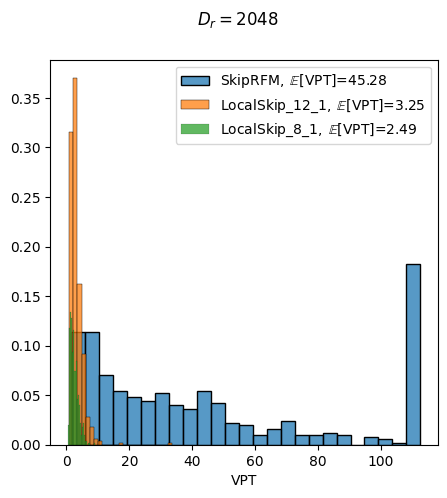

In [9]:
config = f'config_test_{L}'
D_r, B, n = 2048, 1, 10
data_folder = f"{folder}/{config}"
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
# ax1 = fig.add_subplot(122)
for architecture in ['SkipRFM', 'LocalSkip_12_1', 'LocalSkip_8_1']:
    data = pd.read_csv(f'{data_folder}/{architecture}/D_r-{D_r}_B-{B}/batch_data.csv')
    print(data['tau_f_nmse'].max())
    sns.histplot(data['tau_f_nmse'], ax=ax, label=f"{architecture}" + r'$,\;\mathbb{E}[{\rm VPT}]$' + f"={data['tau_f_nmse'].mean():.2f}", bins=25, stat='probability')
    # sns.histplot(data['tau_f_se'], ax=ax1, label=f"{architecture}" + r'$,\;\mathbb{E}[{\tau_f}]$' + f"={data['tau_f_se'].mean():.2f}", bins=25, stat='probability')
ax.set_xlabel(r'VPT')
# ax1.set_xlabel(r'$\tau_f$')
ax.set_ylabel('')
# ax1.set_ylabel('')
ax.legend()
# ax1.legend()
fig.suptitle(f'$D_r=${D_r}')
plt.savefig(f"../data/plots/{dynamical_system}-vpt.png", bbox_inches="tight", dpi=300)

**train and test data**

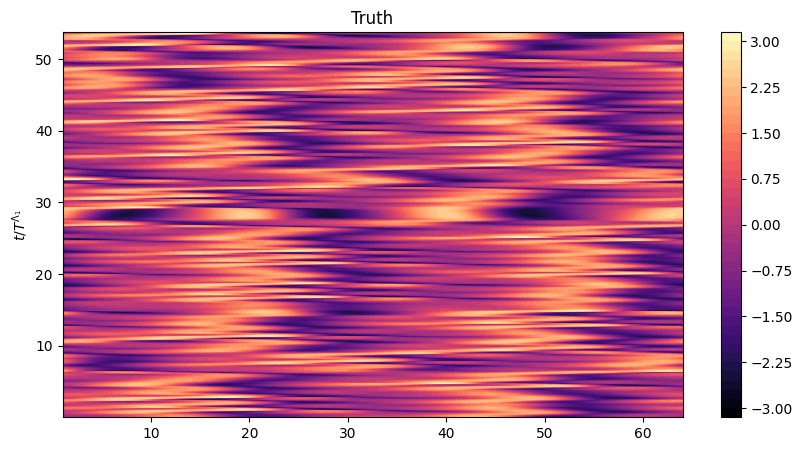

In [4]:
i = np.random.randint(100000-1000)
ut.waterfall(Uo[:, i:i+5000], filename=f"{dynamical_system}-train-partial", levels=50,  **kwargs[L])

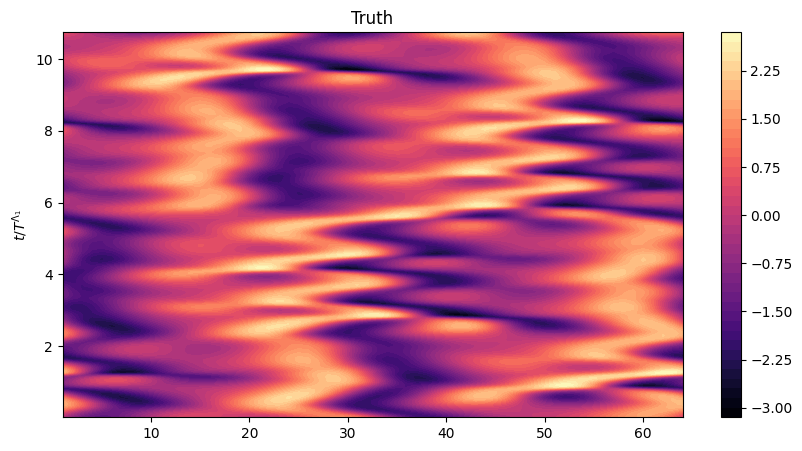

In [29]:
i = np.random.randint(100)
ut.waterfall(Vo[i], filename=f"{dynamical_system}-test-partial", levels=50,  **kwargs[L])

**Spatial autocorrelation at a fixed time**

Text(0.5, 0, 'lag')

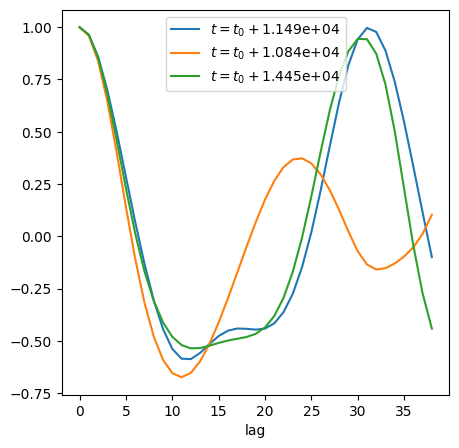

In [6]:
def acf(x, length):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
K = np.random.randint(1e5, size=3)
U = torch.tensor(np.load(f'../data/L96/train.npy'))[:,:100000]
for k in K:
    y = acf(Uo[:, k], 39)
    ax.plot(y, label=r'$t=t_0+$'+f"{kwargs[L]['dt']*k:.4}")
ax.legend()
ax.set_xlabel('lag')

**Localization schemes**

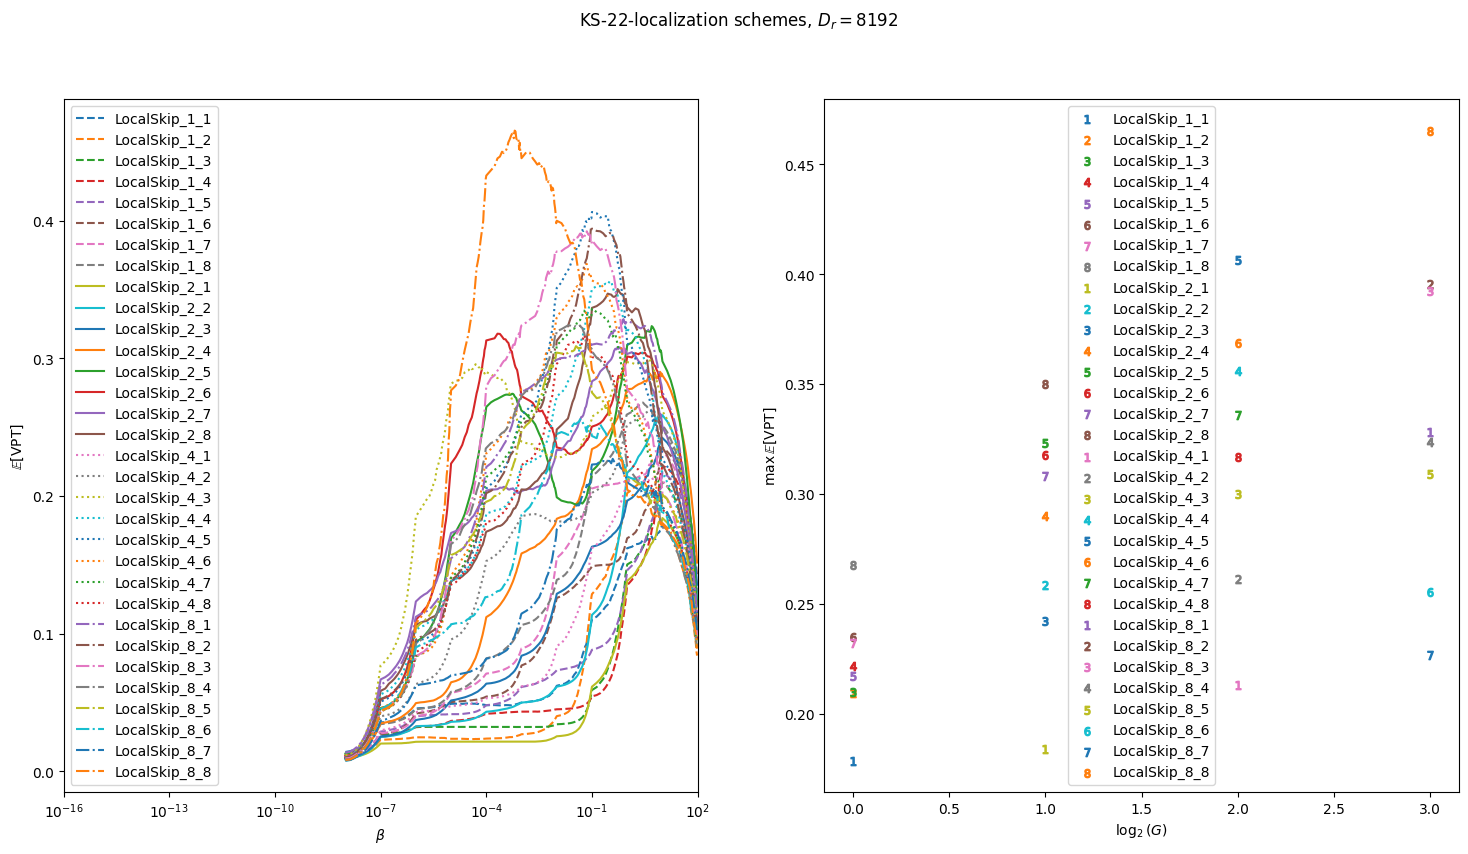

In [7]:
config = 'config_local'
architectures = ['LocalSkip']
GI = [[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8],\
      [2, 1], [2, 2], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 8],\
      [4, 1], [4, 2], [4, 3], [4, 4], [4, 5], [4, 6], [4, 7], [4, 8],\
      [8, 1], [8, 2], [8, 3], [8, 4], [8, 5], [8, 6], [8, 7], [8, 8]]
localizations = [GI]
D_r = 8192
D_rB = [[D_r, 1]] * 8 * 4
structures = [D_rB]
markers = ['x', 'v']
fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
smoothing_window = 50
for i, architecture in enumerate(architectures):
    for j, localization in enumerate(localizations[i]):
        G, I = localization
        D_r, B = structures[i][j]
        if G==1:
            linestyle = 'dashed'
        elif G==2:
            linestyle = 'solid'
        elif G==4:
            linestyle = 'dotted'
        elif G==8:
            linestyle = 'dashdot'
        data = pd.read_csv(f'{folder}/{config}/{architecture}_{G}_{I}/beta/beta_D_r-{D_r}_B-{B}.csv')
        x, y = data['beta'], data['tau_f_nmse_mean']
        y = ut.smooth(y, smoothing_window)
        ax.semilogx(x, y, label=f'{architecture}_{G}_{I}', linestyle=linestyle)
        k = np.argmax(y)
        ax1.scatter(np.log2(G), y[k], label=f'{architecture}_{G}_{I}', marker=r"${}$".format(I))
ax.legend()
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$\mathbb{E}[{\rm VPT}]$')
ax1.legend()
ax1.set_xlabel(r'$\log_2(G)$')
ax1.set_ylabel(r'$\max\,\mathbb{E}[{\rm VPT}]$')
ax.set_xlim((1e-16, 1e2))
fig.suptitle(f'{dynamical_system}-localization schemes, ' + r'${D_r}=$' + f'{D_r}')
plt.savefig(f'../data/plots/{dynamical_system}-localization-schemes-{D_r}.png', bbox_inches='tight', dpi=300)